## William Gordon - BMI 706
## Week 1 / Assignment 1

For my project, I plan to work with the following data sets:
 * NYC Collision Data [https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95]
     * Details of Motor Vehicle Collisions in New York City provided by the Police Department (NYPD)
 * NOAA Storm data [https://www.ncdc.noaa.gov/stormevents/details.jsp]
     * I will actually look at 2 data sources: the storm event data (master file), and the individual fatality data file.
     * The occurrence of storms and other significant weather phenomena having sufficient intensity to cause loss of life, injuries, significant property damage, and/or disruption to commerce;
     * Rare, unusual, weather phenomena that generate media attention, such as snow flurries in South Florida or the San Diego coastal area; and
     * Other significant meteorological events, such as record maximum or minimum temperatures or precipitation that occur in connection with another event.
 * NYC Police Department Complaints Data [https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i]
     * This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD)
 * Zip/Code to Borough Translations [https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm]
     * We will need this to know which zip codes belong to which borough/county (and vice versa)

The data is relational, generally linked by county (The NOAA data, for example), or zip code, so all data sets can be integrated. The NYC collision data and the NYPD complaint data are both time series data (showing events by date), as is the NOAA storm data.

** Setup your development environment and GitHub account **

* My github project is here: https://github.com/willgordon/706_viz_project
* I will use R with ggplot2/plotly for most of my visualizations.  Data manipulation will be done using readr/dplyr.

** Write a 1 page outline of possible questions to be asked, including analyses that need to be conducted in order to visualize the data **




## Summary of proposed project

The overall theme of my project will be using data to understand where I may want to live, should I move to New York.  Fortunately, for the purpose of this project, price is no obstacle--I am primarily interested in safety, from a crime perspective, as well as motor vehicles.  Additionally, insofar that there is a difference between the boroughs in terms of severe weather, I'd like to avoid that as well.  Essentially, I want to know what are the most "liveable' areas of NYC.

To get at these questions, I will explore a few data sets.  First, I will look at a data set of automobile collisions.  This has every collision that was recorded, with date and a variety of other variables about the collission. Second, I will look at severe weather data, offered by the NOAA. This data includes date, the severe weather "type" (blizzard, tornado, etc), along with the location, how it was recorded, and number of fatalities (direct or indirect). Lastly, I will look at NYC police "complaint" data which includes all crimes reported to the NYPD over this time period.  For all data sets, I will look at 4 full years, 2013-2016.

These are 3 large, disparate data sets, so there will need to be a fair bit of work to organize the data in a logical manner (some of this has been done already). There are several axes: first, there is location.  Zip-code and county are the main linkers here - in NYC, each borough is its own county. However, there is missing data (particularly in the collision data set); there is lat/long data here however so we can obtain the country data from the lat/long data to ensure a full data set (since 25% of this is missing). For data sets that do not have lat/long in them, I will need to geocode them based on address. 

Another axis is time.  I have some much of this already (formatting the various date fields into an R date object).  Additionally, there will need to be aggregations done over time, since most of the data is at the event-level. For example, aggregating by collisions per week may be a more useful metric than per day in some area.  These aggregations will make visualizing the data much better.

Finally, there will need to be descriptive natural language processing.  Specifically, for the crime data, the 'descriptions' of the events will need to sorted / processed so that they can be grouped together in a logical way (for example, ""LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UNATTENDED" and ""LARCENY,PETIT FROM OPEN AREAS," should probably be grouped together under "LARCENY".) Other examples exist in the weather data and the collision data. The collision data, for example, has 5 "CONTRIBUTING FACTOR VEHICLE" fields that should be combined and sorted for more useful analysis.


By combining automobile collision data, NYPD criminal complaints, and severe weather data, I hope to get a reasonable sense of the quality of life in certain areas of NYC. Of course this is just one part of the picture, as other variables (cost of living, walkability and access to transit, etc) should all be considered, however as a first pass at "safety" this should be an interesting analysis.

In [1]:
library("tidyverse")
library("ggplot2")
library("plotly")

setwd('/Users/williamgordon/Dropbox (Partners HealthCare)/Classes/BMI706/')
nyc_counties = c('NEW YORK', 'QUEENS', 'BRONX', 'KINGS', 'RICHMOND')

Warning message:
“package ‘tidyverse’ was built under R version 3.3.2”Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
“package ‘ggplot2’ was built under R version 3.3.2”Warning message:
“package ‘tidyr’ was built under R version 3.3.2”Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘plotly’ was built under R version 3.3.2”
Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout



First we will load the collision data:

In [2]:
collisions <- read_csv(file = 'data/NYPD_Motor_Vehicle_Collisions.csv',
                       col_types = list(DATE = col_date(format="%m/%d/%Y"))
                       )


In [3]:
sum(is.na(collisions$`ZIP CODE`) & is.na(collisions$BOROUGH))

[1] 264415

Too many NA values for location.  In the future we will geocode the lat/long to get counties, but for now, lets filter this out:

In [4]:
collisions_filtered = collisions %>% filter(!(is.na(collisions$`ZIP CODE`) & is.na(collisions$BOROUGH)))

Lets get the storm data, combined by years (2013-2016), filter to just NYC counties, and create a Date column

In [5]:
storms_2013 <- read_csv(file = 'data/StormEvents_details-ftp_v1.0_d2013_c20160223.csv')
storms_2014 <- read_csv(file = 'data/StormEvents_details-ftp_v1.0_d2014_c20161118.csv')
storms_2015 <- read_csv(file = 'data/StormEvents_details-ftp_v1.0_d2015_c20170216.csv')
storms_2016 <- read_csv(file = 'data/StormEvents_details-ftp_v1.0_d2016_c20170317.csv')

all_storms <- rbind(storms_2013, storms_2014, storms_2015, storms_2016)
all_storms_filtered <- all_storms %>% filter(STATE == 'NEW YORK' & 
                                               CZ_NAME %in% nyc_counties)
all_storms_filtered$FULL_DATE <- as.Date(paste0(all_storms_filtered$BEGIN_YEARMONTH, all_storms_filtered$BEGIN_DAY), "%Y%m%d")


Parsed with column specification:
cols(
  .default = col_character(),
  BEGIN_YEARMONTH = col_integer(),
  BEGIN_DAY = col_integer(),
  BEGIN_TIME = col_integer(),
  END_YEARMONTH = col_integer(),
  END_DAY = col_integer(),
  END_TIME = col_integer(),
  EPISODE_ID = col_integer(),
  EVENT_ID = col_integer(),
  STATE_FIPS = col_integer(),
  YEAR = col_integer(),
  CZ_FIPS = col_integer(),
  INJURIES_DIRECT = col_integer(),
  INJURIES_INDIRECT = col_integer(),
  DEATHS_DIRECT = col_integer(),
  DEATHS_INDIRECT = col_integer(),
  MAGNITUDE = col_double(),
  TOR_LENGTH = col_double(),
  TOR_WIDTH = col_integer(),
  BEGIN_RANGE = col_integer(),
  END_RANGE = col_integer()
  # ... with 4 more columns
)
See spec(...) for full column specifications.
Warning message:
“1 parsing failure.
  row       col               expected actual
52629 TOR_WIDTH no trailing characters     .8
”Parsed with column specification:
cols(
  .default = col_character(),
  BEGIN_YEARMONTH = col_integer(),
  BEGIN_DAY =

Next, get NYPD complaints data. Note: much of this was done already (it took a long time to process, so I saved it as a CSV. Commented code is what I did prior.)

In [6]:
# NYPD Complaint Data: 2006-2015
# complaints_all <- read_csv(file = 'data/NYPD_Complaint_Data_Historic.csv',
#                            col_types = list(CMPLNT_FR_DT = col_date(format="%m/%d/%Y"),
#                                             CMPLNT_TO_DT = col_date(format="%m/%d/%Y"))
#                            )
# complaints_2013_2015 <- complaints_all %>% filter(CMPLNT_FR_DT > '2013-01-01')
# 
# complaints_ytd <- read_csv(file = 'data/NYPD_Complaint_Data_Current_YTD.csv',
#                            col_types = list(CMPLNT_FR_DT = col_date(format="%m/%d/%Y"),
#                                             CMPLNT_TO_DT = col_date(format="%m/%d/%Y"))
#                            )
# 
# complaints_2013_2016 <- bind_rows(complaints_2013_2015, complaints_ytd)
# write.csv(complaints_2013_2016, file = 'data/complaints_2013_2016.csv')

complaints_2013_2016 <- read_csv(file = 'data/complaints_2013_2016.csv')


Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_integer(),
  CMPLNT_NUM = col_integer(),
  CMPLNT_FR_DT = col_date(format = ""),
  CMPLNT_FR_TM = col_integer(),
  CMPLNT_TO_DT = col_date(format = ""),
  CMPLNT_TO_TM = col_integer(),
  KY_CD = col_integer(),
  PD_CD = col_integer(),
  ADDR_PCT_CD = col_integer(),
  X_COORD_CD = col_integer(),
  Y_COORD_CD = col_integer(),
  Latitude = col_double(),
  Longitude = col_double()
)
See spec(...) for full column specifications.


Lastly, zip-code to borough/county translations:

In [7]:
county_nhood_zip <- read_csv(file = 'data/county_nhood_zip.csv',
                             col_names = FALSE
                             )


Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_character()
)


Summary Statistics.

Lets look at the motor vehicle collisions first.

Number of collisions and number of collisions by month:

[1] 1000981


   01    02    03    04    05    06    07    08    09    10    11    12 
83792 77461 81433 67915 76077 74856 90643 89636 89307 92168 87968 89725 

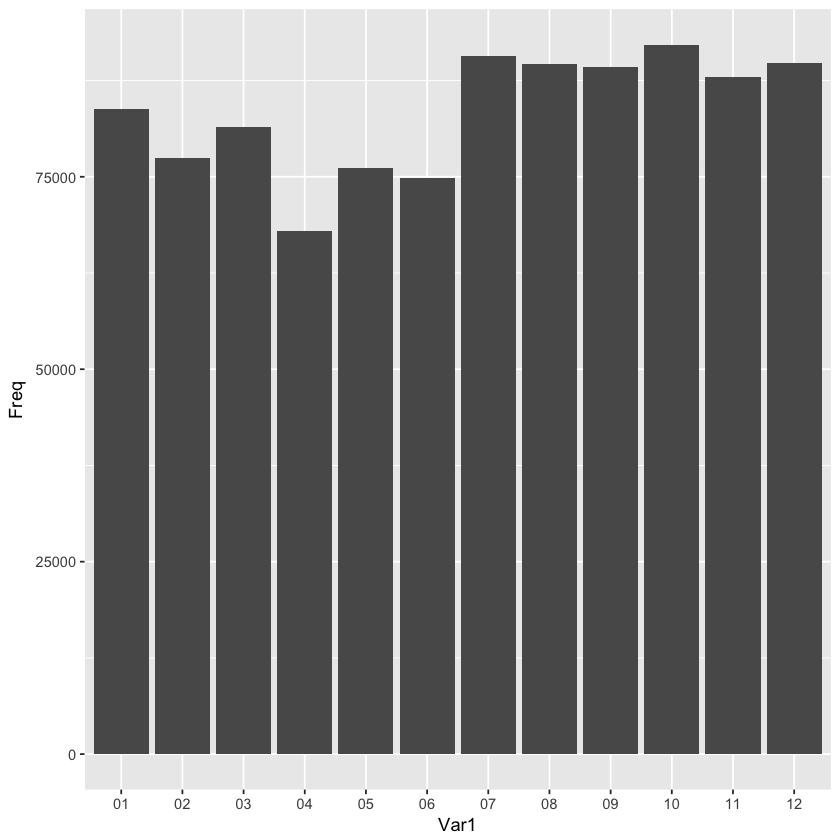

In [11]:
nrow(collisions)
table(format.Date(collisions$DATE, "%m"))
month_counts <- as.data.frame(table(format.Date(collisions$DATE, "%m")))
ggplot(month_counts, aes(Var1, Freq)) + geom_bar(stat="identity")


Lets look by borough:

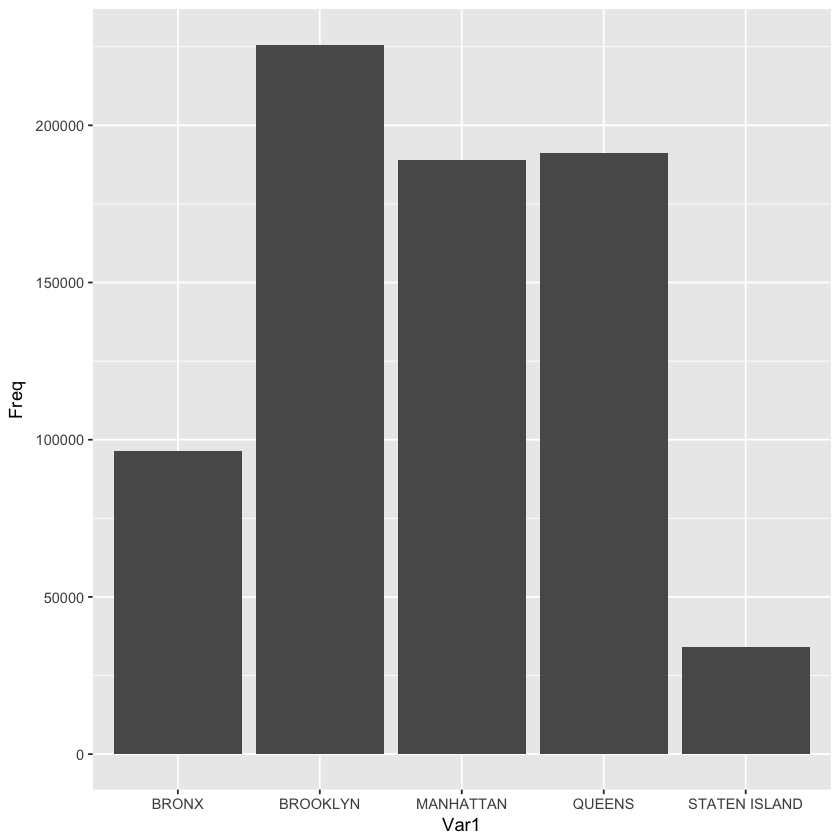

In [12]:
borough_counts <- as.data.frame(table(collisions$BOROUGH))
ggplot(borough_counts, aes(Var1, Freq)) + geom_bar(stat="identity")

Now lets move on to the weather data. 

How many severe weather events were recorded, across all 5 counties (and per county), during this time period? What were the severe weather types? Did people die from this severe weather?

In [13]:
nrow(all_storms_filtered)

[1] 81

In [14]:
table(all_storms_filtered$CZ_NAME)


   BRONX    KINGS NEW YORK   QUEENS RICHMOND 
      29       14        7       24        7 

In [15]:
table(all_storms_filtered$EVENT_TYPE)


         Blizzard     Coastal Flood         Dense Fog    Excessive Heat 
                1                 1                 1                 2 
      Flash Flood             Flood        Heavy Rain        Heavy Snow 
               25                 5                 1                 7 
        High Wind         Lightning       Strong Wind Thunderstorm Wind 
                1                 4                 1                25 
     Winter Storm    Winter Weather 
                4                 3 

In [17]:
all_storms_filtered[all_storms_filtered$DEATHS_DIRECT > 0 | all_storms_filtered$DEATHS_INDIRECT >0,]
nrow(all_storms_filtered[all_storms_filtered$DEATHS_DIRECT > 0 | all_storms_filtered$DEATHS_INDIRECT >0,])

BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,⋯,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FULL_DATE
201307,19,0,201307,21,0,76042,458783,NEW YORK,36,⋯,NA,NA,NA,NA,NA,NA,A large area of high pressure remained nearly stationary to the south for almost a week. This resulted in a prolonged period of high to excessive heat across the area.,"The NYC medical examiner's office reported the death of a female, age 83 years old, as a result of the intense and excessive heat for several days. The death occurred in the Bronx on 7/20/13.",CSV,2013-07-19


[1] 1

In [ ]:
Finally, lets look at our crime data - all NYPD incidents and complaints.

Totals by borough, then by month.

In [19]:
table(complaints_2013_2016$BORO_NM)


        BRONX      BROOKLYN     MANHATTAN        QUEENS STATEN ISLAND 
       418755        578429        456439        388165         88809 

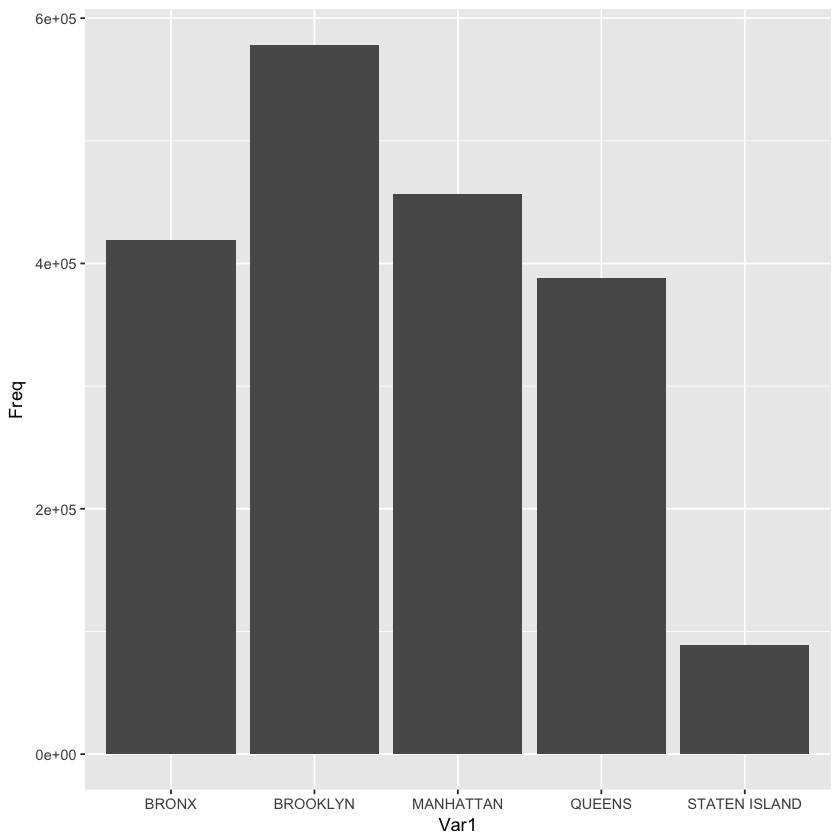

In [22]:
crime_counts <- as.data.frame(table(complaints_2013_2016$BORO_NM))
ggplot(crime_counts, aes(Var1, Freq)) + geom_bar(stat="identity")

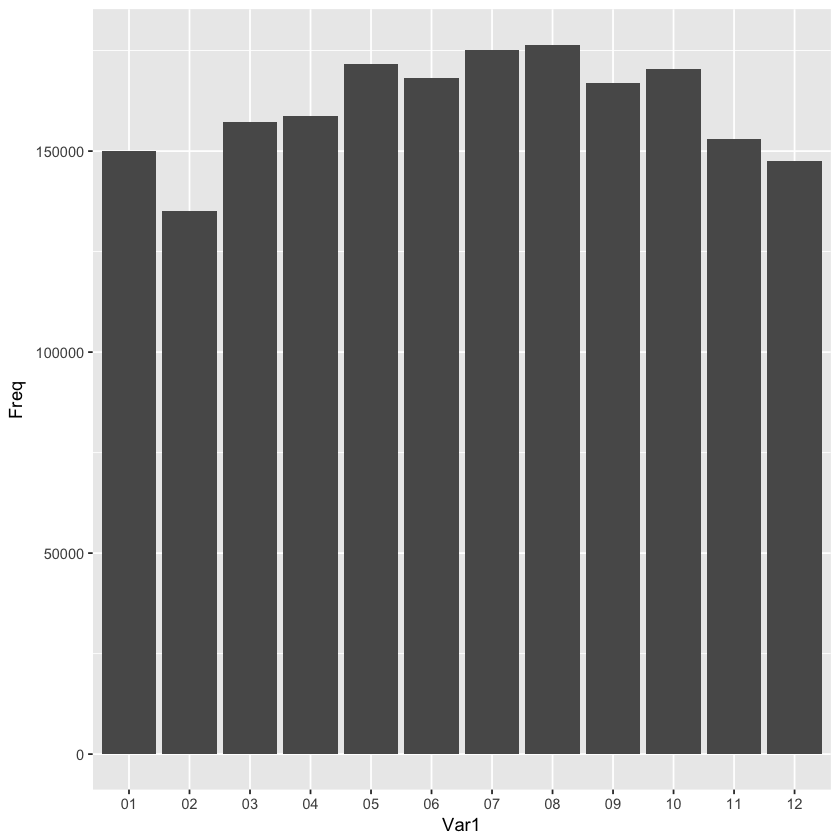

In [23]:
month_counts <- as.data.frame(table(format.Date(complaints_2013_2016$CMPLNT_FR_DT, "%m")))
ggplot(month_counts, aes(Var1, Freq)) + geom_bar(stat="identity")


Our county/zipcode/borough CSV can just be dumped:

In [24]:
county_nhood_zip

X1,X2,X3
BRONX,Central Bronx,"10453, 10457, 10460"
BRONX,Bronx Park and Fordham,"10458, 10467, 10468"
BRONX,High Bridge and Morrisania,"10451, 10452, 10456"
BRONX,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474"
BRONX,Kingsbridge and Riverdale,"10463, 10471"
BRONX,Northeast Bronx,"10466, 10469, 10470, 10475"
BRONX,Southeast Bronx,"10461, 10462,10464, 10465, 10472, 10473"
BROOKLYN,Central Brooklyn,"11212, 11213, 11216, 11233, 11238"
BROOKLYN,Southwest Brooklyn,"11209, 11214, 11228"
BROOKLYN,Borough Park,"11204, 11218, 11219, 11230"
